### Notes
- When multiple data files are loaded, the functions that Karena has used to get the summertime labor capacity return an error, related to attempting to apply functions along an axis that does not exist.
- I tried to implement a more xarray-oriented solution, but `groupby` is not playing nicely with `sortby`
- Cannot discern from Karena's code whether I am doing the right thin - to extract the summertime mean labor capacity and then plot this...?

In [56]:
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import cftime

In [115]:
def year_max(ds):
    '''Gets the mean labor capacity in hottest three months of a given year'''
    ds_sorted=np.partition(ds,3)
    return ds_sorted[0:3].mean() #three months with lowest labor capacity
    
def max_avg(ds,years=151):
    '''Splits time dimension into years and passes on to year_max to get yearly baseline for capacity'''
    ds_yearly = np.array_split(ds,years)
    ds_max = np.apply_along_axis(year_max,1,ds_yearly)
    return ds_max

def year_max_xr(da):
    return da.sortby(da)[0:3].mean('time')
    
def max_avg_xr(ds):
    '''Splits time dimension into years and passes on to year_max to get yearly baseline for capacity'''
    ds_yearly = xr.groupby('time.year'years)
    ds_max = np.apply_along_axis(year_max,1,ds_yearly)
    return ds_max

def calc_capacity(ds):
    '''Wrapper to calculate max_avg over dataset'''
    return xr.apply_ufunc(max_avg,ds['capacity'],
                          input_core_dims=[['time']],output_core_dims=[['year']],
                          exclude_dims=set(('time',)),vectorize=True,dask='allowed')

def calc_baseline(ds):
    '''Calculates 1980-2000 baseline capacity, by month (mean - 2*std)'''
    # Slice 1980-2000 data
    ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

    # Calculate mean and stdev
    ds_hist = xr.apply_ufunc(max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
    ds_hist_mean = ds_hist.mean(['ensemble','year'])
    ds_hist_dev = ds_hist.std(['ensemble','year'])
    
    # Return baseline as the lower bound of "envelope" around mean 
    ds_base = ds_hist_mean - 2*ds_hist_dev
    return ds_hist

In [116]:
ds = xr.open_dataset('/home/aos/kyan/pei/data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens001-003_1950-2100.nc')
                       #combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds = ds.rename({'__xarray_dataarray_variable__':'capacity'})
ds = ds.sel(lat=25.2,lon=55.27,method='nearest')
ds

<xarray.Dataset>
Dimensions:   (ensemble: 3, time: 1812)
Coordinates:
  * time      (time) object 1950-01-31 00:00:00 ... 2100-12-31 00:00:00
    pfull     float64 ...
    lat       float64 25.28
    lon       float64 56.25
Dimensions without coordinates: ensemble
Data variables:
    capacity  (ensemble, time) float32 ...

In [129]:
da = ds['capacity'].isel(ensemble=0,time=slice(0,12))
da.sortby(da)[0:3].mean('time')

<xarray.DataArray 'capacity' ()>
array(87.825096, dtype=float32)
Coordinates:
    pfull    float64 996.1
    lat      float64 25.28
    lon      float64 56.25

In [133]:
def year_max_xr(x):
    return x.sortby(x)[0:3].mean('time')

ds_years = ds['capacity'].groupby('time.year')#.map(year_max_xr)
ds_years.map(year_max_xr,shortcut=True)
# years = 151
# ds_yearly = np.array_split(ds['capacity'],years)
# ds_max = np.apply_along_axis(year_max,1,ds_yearly)

AttributeError: 'Variable' object has no attribute 'sortby'

In [100]:
years = ds['time'].coarsen(time=12).mean()

In [101]:
with ProgressBar():
    l = calc_capacity(ds).compute()
l = l.assign_coords({'year':years.values})
mean = l.sel(year=slice('1980','2000')).mean(['ensemble','year'])
std = l.sel(year=slice('1980','2000')).std(['ensemble','year'])
base = mean-2*std
r25 = 0.75*base
r50 = 0.5*base

(0.0, 100.0)

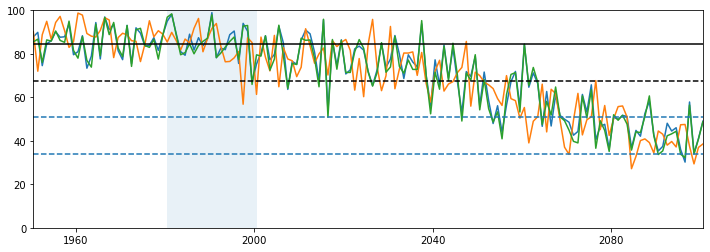

In [102]:
yearmin = l['year'][0].values
yearmax = l['year'][-1].values
year1980 = l['year'].sel(year='1980',method='nearest').values
year2000 = l['year'].sel(year='2000',method='nearest').values

fig,ax=plt.subplots(figsize=(12,4))
ax.plot(l['year'],l.transpose())
ax.axhline(y=mean,color='k')
ax.axhline(y=base,color='k',linestyle='--')
ax.axhline(y=r25,color='tab:blue',linestyle='--')
ax.axhline(y=r50,color='tab:blue',linestyle='--')
ax.fill_betweenx(y=[0,100],x1=year1980,x2=year2000,alpha=0.1)
ax.set_xlim(yearmin,yearmax);
ax.set_ylim(0,100)
# ax.plot(['1980','2000'],[mean,mean])
# l.plot(hue='ensemble')

In [76]:
year1980

array([cftime.DatetimeNoLeap(1980, 7, 15, 22, 0, 0, 0)], dtype=object)

In [52]:
years

<xarray.DataArray 'time' (time: 151)>
array([cftime.DatetimeNoLeap(1950, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1951, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1952, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1953, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1954, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1955, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1956, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1957, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1958, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1959, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1960, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1961, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1962, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1963, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1964, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1965, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1966, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1967, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1968, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(1969, 7, 15, 22, 0, 0, 0),
...
       cftime.DatetimeNoLeap(2081, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2082, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2083, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2084, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2085, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2086, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2087, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2088, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2089, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2090, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2091, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2092, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2093, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2094, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2095, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2096, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2097, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2098, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2099, 7, 15, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 7, 15, 22, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1950-07-15 22:00:00 ... 2100-07-15 22:00:00
    pfull    float64 ...
    lat      float64 25.28
    lon      float64 56.25

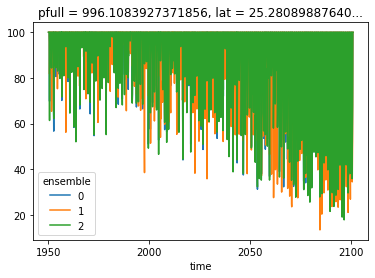

In [18]:
ds_dubai.plot(hue='ensemble')

In [65]:
1812/12

151.0